# data clean
Remove null values:

If the review is a null record

Label definition:
Use ratings to define emotional tags:

    Score 8-10: positive

    Score 4-7: neutral

    Score 1-3: negative

Data sample division (optional) :

For the convenience of model learning, uniform sampling can be conducted from each category.

# Process the review text:

    Lowercase (lowercasing

    Remove punctuation marks

    tokenization

    Remove stop words (such as "the", "and", "is")

    Optional: stemming (stemming) or lemmatization

In [9]:
import pandas as pd
import html
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import os
import platform

# Set the SSL certificate path for MacOS
if platform.system() == 'Darwin':  # Darwin是MacOS的内核名称
    os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/cert.pem"


# Download the necessary NLTK resources (if not yet downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_drug_reviews(file_path, output_path=None):
    """
    Conduct a comprehensive cleaning and preprocessing of the drug review dataset. 
    Parameters: 
        file_path: Input CSV file path. 
        output_path: Output CSV file path, default is None. 
    Return: 
        Cleaned DataFrame
    """
    # 1. Read the data
    print("read data...")
    df = pd.read_csv(file_path)
    
    # 2. delete the empty value
    print("delete the empty value...")
    original_count = len(df)
    df = df.dropna(subset=['review'])
    print(f"delete {original_count - len(df)} empty values")
    
    # 3. deal with HTML entities
    print("deal with HTML entities...")
    df['review_clean'] = df['review'].apply(lambda x: html.unescape(x) if isinstance(x, str) else x)
    
    # 4. Remove the quotation marks (nested quotation marks in CSV files)
    df['review_clean'] = df['review_clean'].apply(lambda x: x.strip('"') if isinstance(x, str) else x)
    
    # 5. Remove special symbols and non-English characters and convert them to lowercase
    print("Clean up the text...")
    def clean_text(text):
        if not isinstance(text, str):
            return ""
        # Remove non-English characters and special symbols, 
        # and retain letters, numbers, Spaces and basic punctuation
        text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)
        # strtolower
        text = text.lower()
        # Replace multiple Spaces with a single space
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df['review_clean'] = df['review_clean'].apply(clean_text)
    
    # 6. Use NLTK for sentence segmentation
    print("Sentence segmentation processing...")
    df['sentences'] = df['review_clean'].apply(lambda x: sent_tokenize(x) if x else [])
    
    # 7. Use NLTK for word segmentation
    print("word segmentation...")
    df['tokens'] = df['review_clean'].apply(lambda x: word_tokenize(x) if x else [])
    
    # 8. Remove stop words
    print("Remove stop words...")
    stop_words = set(stopwords.words('english'))
    df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    
    # 9. Word drying and word form reduction
    print("Word drying and word form reduction...")
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    df['tokens_stemmed'] = df['tokens_no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
    df['tokens_lemmatized'] = df['tokens_no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # 10. Define emotional labels
    print("Define emotional labels...")
    def get_sentiment(rating):
        if rating >= 8:
            return 'positive'
        elif rating >= 4:
            return 'neutral'
        else:
            return 'negative'
    
    df['sentiment'] = df['rating'].apply(get_sentiment)
    
    # 11. Save the cleaned data (if an output path is provided)
    if output_path:
        print(f"Save the cleaned data to {output_path}...")
        df.to_csv(output_path, index=False)
    
    print("Data cleaning is completed!")
    return df

[nltk_data] Downloading package punkt to /Users/ghostguy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ghostguy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ghostguy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ghostguy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Add data exploration and visualization functions

In [10]:
def explore_drug_reviews(df):
    """
    Explore the cleaned drug review data
    
    Parameters:
        df: Cleaned DataFrame
    """
    print(f"Dataset contains {len(df)} reviews")
    
    # Check sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    print("\nSentiment distribution:")
    print(sentiment_counts)

    # Check rating distribution
    rating_counts = df['rating'].value_counts().sort_index()
    print("\nRating distribution:")
    print(rating_counts)

    # Check common drugs
    drug_counts = df['drugName'].value_counts().head(10)
    print("\nTop 10 most common drugs:")
    print(drug_counts)
    
    # Check common conditions
    condition_counts = df['condition'].value_counts().head(10)
    print("\nTop 10 most common conditions:")
    print(condition_counts)

    # Check vocabulary statistics
    token_lengths = df['tokens'].apply(len)
    print("\nVocabulary statistics:")
    print(f"Average words per review: {token_lengths.mean():.2f}")
    print(f"Minimum word count: {token_lengths.min()}")
    print(f"Maximum word count: {token_lengths.max()}")
    
    return {
        'sentiment_counts': sentiment_counts,
        'rating_counts': rating_counts,
        'drug_counts': drug_counts,
        'condition_counts': condition_counts,
        'token_lengths': token_lengths
    }

def visualize_data(stats):
    """
    Visualize data statistics
    
    Parameters:
        stats: Data statistics dictionary
    """
    # Set up canvas
    plt.figure(figsize=(15, 12))

    # 1. Sentiment distribution pie chart
    plt.subplot(2, 2, 1)
    plt.pie(stats['sentiment_counts'], labels=stats['sentiment_counts'].index,
            autopct='%1.1f%%', startangle=90)
    plt.title('Sentiment Distribution')

    # 2. Rating distribution bar chart
    plt.subplot(2, 2, 2)
    sns.barplot(x=stats['rating_counts'].index,
                y=stats['rating_counts'].values)
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Count')

    # 3. Common drugs bar chart
    plt.subplot(2, 2, 3)
    sns.barplot(x=stats['drug_counts'].values, y=stats['drug_counts'].index)
    plt.title('Top 10 Most Common Drugs')
    plt.xlabel('Count')

    # 4. Word count distribution histogram
    plt.subplot(2, 2, 4)
    sns.histplot(stats['token_lengths'], bins=50, kde=True)
    plt.title('Review Word Count Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('drug_reviews_stats.png')
    plt.show()

# Add a simple sentiment analysis model


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def create_sentiment_model(df, model_type='logistic'):
    """
    Create sentiment analysis model
    
    Parameters:
        df: Cleaned DataFrame
        model_type: Model type, options include 'logistic', 'naive_bayes', 'svm', 'random_forest'
    
    Returns:
        Model, vectorizer and evaluation results
    """
    print("Creating sentiment analysis model...")
    
    # Prepare data
    X = df['review_clean']
    y = df['sentiment']

    # Split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Feature extraction - TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Select model
    if model_type == 'naive_bayes':
        model = MultinomialNB()
    elif model_type == 'svm':
        model = LinearSVC()
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100)
    else:  # Default logistic regression
        model = LogisticRegression(max_iter=1000)

    # Train model
    print(f"Training {model_type} model...")
    model.fit(X_train_vec, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_vec)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Model accuracy: {accuracy:.4f}")
    print("\nConfusion matrix:")
    print(conf_matrix)
    print("\nClassification report:")
    print(class_report)

    # Return the model, vectorizer and evaluation results
    results = {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
    
    return results

def analyze_feature_importance(model_results, top_n=20):
    """
        Analyze the most important features in the model
        
        Parameters:
            model_results: Model results dictionary
            top_n: Number of top features to return
    """ 
    model = model_results['model']
    vectorizer = model_results['vectorizer']
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract feature importance for different model types
    if isinstance(model, LogisticRegression) or isinstance(model, LinearSVC):
        # For linear models, use coefficients as feature importance
        try:
            coefficients = model.coef_[0] if len(model.coef_.shape) > 1 else model.coef_
            # Sort by absolute value
            top_indices = np.argsort(np.abs(coefficients))[-top_n:]
            top_features = [(feature_names[i], coefficients[i]) for i in top_indices]
            top_features.reverse() 
        except:
            return "This model does not support feature importance analysis"
    
    elif isinstance(model, RandomForestClassifier):
        # For random forest, use built-in feature importance
        importances = model.feature_importances_
        top_indices = np.argsort(importances)[-top_n:]
        top_features = [(feature_names[i], importances[i]) for i in top_indices]
        top_features.reverse()
    
    elif isinstance(model, MultinomialNB):
        # For naive Bayes, use feature log probabilities
        class_log_prior = model.class_log_prior_
        feature_log_prob = model.feature_log_prob_
        
        # Assuming binary classification, take difference between first and second class
        if len(feature_log_prob) >= 2:
            log_prob_diff = feature_log_prob[0] - feature_log_prob[1]
            top_indices = np.argsort(np.abs(log_prob_diff))[-top_n:]
            top_features = [(feature_names[i], log_prob_diff[i]) for i in top_indices]
            top_features.reverse()
        else:
            return "This model does not support feature importance analysis"
    
    else:
        return "This model does not support feature importance analysis"
    
    # Visualize feature importance
    plt.figure(figsize=(10, 8))
    
    feature_names = [f[0] for f in top_features]
    feature_importances = [f[1] for f in top_features]
    
    plt.barh(range(len(feature_names)), feature_importances, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Top Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    return top_features

# Multiple data mining and text analysis tools:
    SketchEngine integration
SketchEngine is a powerful corpus analysis tool that can be used for keyword extraction, word frequency analysis, etc

    1. Integration of Weka data Mining tools
Weka is a popular data mining software that can apply a variety of machine learning algorithms without writing code.

    1. Integration of ChatGPT/OpenAI API
Analyze drug reviews with ChatGPT to gain a deeper semantic understanding:

    1. Add Transformer model integration
Drug review analysis using Hugging Face's pre-trained model:

In [12]:
def integrate_sketch_engine(df, output_dir="sketch_engine_data"):
    """
    Prepare data for SketchEngine and generate analysis guide
    """
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 1. Export positive reviews to text file
    positive_reviews = df[df['sentiment'] == 'positive']['review_clean']
    with open(f"{output_dir}/positive_reviews.txt", "w") as f:
        f.write("\n".join(positive_reviews.tolist()))
    
    # 2. Export negative reviews to text file
    negative_reviews = df[df['sentiment'] == 'negative']['review_clean']
    with open(f"{output_dir}/negative_reviews.txt", "w") as f:
        f.write("\n".join(negative_reviews.tolist()))
    
    # 3. Export neutral reviews to text file
    neutral_reviews = df[df['sentiment'] == 'neutral']['review_clean']
    with open(f"{output_dir}/neutral_reviews.txt", "w") as f:
        f.write("\n".join(neutral_reviews.tolist()))
    
    # 4. Generate SketchEngine usage guide
    guide = """
    SketchEngine Analysis Guide:
    
    1. Go to https://www.sketchengine.eu/ and log in
    2. Create a new corpus and upload the exported text files
    3. Perform the following analyses on the uploaded corpus:
       - Word frequency analysis
       - Keyword extraction
       - Word collocation analysis (Word Sketches)
       - Word comparison (Word Sketch Difference)
    4. Compare language features across different sentiment reviews
    5. Export analysis results for reporting
    """
    
    with open(f"{output_dir}/sketch_engine_guide.txt", "w") as f:
        f.write(guide)
    
    print(f"Data exported to {output_dir} directory for SketchEngine analysis")
    print("Check sketch_engine_guide.txt for usage instructions")
    
    return {
        "positive_count": len(positive_reviews),
        "negative_count": len(negative_reviews),
        "neutral_count": len(neutral_reviews),
        "export_path": output_dir
    }

def export_for_weka(df, output_path="dataset/drug_reviews_weka.arff"):
    """
    Export data in ARFF format for Weka
    """
    import os
    
    # Create directory (if it doesn't exist)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # 1. Use TF-IDF to get main features
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    print("Preparing data for Weka...")
    print("Extracting features using TF-IDF...")
    
    # Extract up to 500 features to keep ARFF file size reasonable
    vectorizer = TfidfVectorizer(max_features=500)
    X = vectorizer.fit_transform(df['review_clean'])
    feature_names = vectorizer.get_feature_names_out()
    
    # Create DataFrame with features
    import pandas as pd
    import numpy as np
    weka_df = pd.DataFrame(X.toarray(), columns=feature_names)
    weka_df['sentiment'] = df['sentiment'].values
    
    # 2. Export to ARFF format
    print(f"Exporting to ARFF file: {output_path}")
    
    with open(output_path, 'w') as f:
        # Write ARFF header
        f.write("@RELATION drug_reviews\n\n")
        
        # Write attributes
        for feature in feature_names:
            # Replace characters unsuitable for ARFF
            safe_feature = feature.replace(" ", "_").replace(",", "_").replace("'", "").replace("\"", "")
            f.write(f"@ATTRIBUTE {safe_feature} NUMERIC\n")
        
        # Write target attribute
        f.write("@ATTRIBUTE sentiment {positive,neutral,negative}\n\n")
        
        # Write data
        f.write("@DATA\n")
        for i, row in weka_df.iterrows():
            feature_values = [str(row[feature]) for feature in feature_names]
            values_str = ",".join(feature_values) + "," + row['sentiment']
            f.write(values_str + "\n")
    
    # 3. Generate Weka usage guide
    guide_path = os.path.join(os.path.dirname(output_path), "weka_guide.txt")
    guide = """
    Weka Usage Guide:
    
    1. Download and install Weka: https://www.cs.waikato.ac.nz/ml/weka/
    2. Launch Weka Explorer
    3. Load the exported ARFF file
    4. Try the following algorithms in the "Classify" tab:
       - J48 (Decision Tree)
       - RandomForest
       - SMO (SVM implementation)
       - NaiveBayes
    5. Evaluate models using 10-fold cross-validation
    6. Compare performance across different algorithms
    7. View decision tree visualization to understand important features
    8. Save results for reporting
    """
    
    with open(guide_path, 'w') as f:
        f.write(guide)
    
    print(f"Successfully exported Weka data, feature count: {len(feature_names)}")
    print(f"Weka usage guide saved to: {guide_path}")
    
    return {
        "feature_count": len(feature_names),
        "sample_count": len(weka_df),
        "arff_path": output_path,
        "guide_path": guide_path
    }

def analyze_with_chatgpt(df, api_key=None, sample_size=5):
    """
    Analyze drug reviews using ChatGPT API
    
    Parameters:
        df: DataFrame containing reviews
        api_key: OpenAI API key (optional)
        sample_size: Number of samples to analyze
    """
    print("\n" + "=" * 50)
    print("ChatGPT Drug Review Analysis")
    print("=" * 50)
    
    # If no API key is provided, generate example prompts
    if api_key is None:
        print("No API key provided, generating example prompts for manual analysis")
        
        # Sample from each sentiment category
        samples = []
        for sentiment in df['sentiment'].unique():
            sentiment_samples = df[df['sentiment'] == sentiment].sample(
                min(int(sample_size/3), sum(df['sentiment'] == sentiment)), 
                random_state=42
            )
            samples.append(sentiment_samples)
        
        sample_df = pd.concat(samples)
        
        # Generate prompts for each sample
        prompts = []
        for i, row in sample_df.iterrows():
            prompt = f"""
            Please analyze the following drug review and provide:
            1. Overall sentiment (positive/negative/neutral)
            2. Main themes (e.g., efficacy, side effects, price)
            3. Specific drug effects mentioned
            4. Patient's overall attitude toward the drug
            
            Review: "{row['review_clean'][:500]}..."
            
            Detailed analysis:
            """
            prompts.append(prompt)
        
        # Save prompts to file
        prompt_file = "chatgpt_prompts.txt"
        with open(prompt_file, "w") as f:
            for i, prompt in enumerate(prompts):
                f.write(f"===== Prompt {i+1} =====\n")
                f.write(prompt + "\n\n")
        
        print(f"Generated {len(prompts)} ChatGPT prompts, saved to {prompt_file}")
        print("Please manually input these prompts to ChatGPT and record the analysis results")
        
        # Generate usage guide
        guide = """
        ChatGPT Usage Guide:
        
        1. Visit https://chat.openai.com/ or use the OpenAI API
        2. Use the generated prompts to analyze drug reviews
        3. Record ChatGPT's responses
        4. Incorporate analysis results into your research report
        5. Compare ChatGPT's analysis with traditional models
        
        Note: Deep analysis may reveal subtle sentiments and themes difficult to capture with traditional methods
        """
        
        guide_file = "chatgpt_guide.txt"
        with open(guide_file, "w") as f:
            f.write(guide)
        
        print(f"ChatGPT usage guide saved to {guide_file}")
        
        return {
            "prompt_file": prompt_file,
            "guide_file": guide_file,
            "sample_count": len(prompts)
        }
    
    else:
        # Actual API call code
        try:
            import openai
            openai.api_key = api_key
            
            # Sample reviews
            samples = df['review_clean'].sample(sample_size, random_state=42)
            results = []
            
            for i, review in enumerate(samples):
                print(f"Analyzing review {i+1}/{sample_size}...")
                
                try:
                    response = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        messages=[
                            {"role": "system", "content": "You are a professional drug review analyst."},
                            {"role": "user", "content": f"""
                            Please analyze the following drug review and provide:
                            1. Overall sentiment (positive/negative/neutral)
                            2. Main themes (e.g., efficacy, side effects, price)
                            3. Specific drug effects mentioned
                            4. Patient's overall attitude toward the drug
                            
                            Review: "{review[:500]}..."
                            """}
                        ]
                    )
                    
                    analysis = response.choices[0].message.content
                    results.append({
                        "review": review[:200] + "...",
                        "analysis": analysis
                    })
                    
                except Exception as e:
                    print(f"Error analyzing review: {e}")
                    results.append({
                        "review": review[:200] + "...",
                        "analysis": f"Analysis failed: {str(e)}"
                    })
            
            # Save results
            result_file = "chatgpt_analyses.txt"
            with open(result_file, "w") as f:
                for i, result in enumerate(results):
                    f.write(f"===== Review {i+1} =====\n")
                    f.write(result["review"] + "\n\n")
                    f.write("==Analysis==\n")
                    f.write(result["analysis"] + "\n\n")
            
            print(f"Completed analysis of {len(results)} reviews, results saved to {result_file}")
            
            return {
                "result_file": result_file,
                "analyses": results
            }
            
        except ImportError:
            print("openai package not installed, please install with: pip install openai")
            return None
        
def analyze_with_transformers(df, sample_size=10):
    """
    Analyze drug reviews using Transformer models
    
    Parameters:
        df: DataFrame containing reviews
        sample_size: Number of samples to analyze
    """
    print("\n" + "=" * 50)
    print("Transformer Model Drug Review Analysis")
    print("=" * 50)
    
    # Check if required libraries are installed
    try:
        from transformers import pipeline
        import torch
        import os

        os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/cert.pem"
        os.environ["HF_ENDPOINT"] = "https://hf-mirror.com" 
        
        # Check for GPU availability
        device = 0 if torch.cuda.is_available() else -1
        print(f"Using device: {'GPU' if device == 0 else 'CPU'}")
        
        # Create sentiment analysis pipeline
        print("Loading pre-trained sentiment analysis model...")
        try:
            sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english",
                # local_files_only=True,  # Prioritize using local cache
                device=device
            )
            print("Successfully using local cached model")
        except Exception as e:
            print(f"Cannot use local model: {e}")
            print("Attempting to download smaller model from server...")
            sentiment_analyzer = pipeline(
                "sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english",
                device=device
            )
        
        # Sample from each sentiment category
        samples = []
        for sentiment in df['sentiment'].unique():
            sentiment_samples = df[df['sentiment'] == sentiment].sample(
                min(int(sample_size/3), sum(df['sentiment'] == sentiment)), 
                random_state=42
            )
            samples.append(sentiment_samples)
        
        sample_df = pd.concat(samples)
        
        # Perform sentiment analysis
        print("Analyzing sentiment using Transformer model...")
        results = []
        
        for i, row in sample_df.iterrows():
            # Limit to 512 characters due to model input length constraints
            text = row['review_clean'][:512]
            true_sentiment = row['sentiment']
            
            # Analyze sentiment
            try:
                prediction = sentiment_analyzer(text)[0]
                predicted_label = prediction['label']
                score = prediction['score']
                
                results.append({
                    "text": text[:100] + "...",
                    "true_sentiment": true_sentiment,
                    "predicted_label": predicted_label,
                    "confidence": score
                })
                
                print(f"Sample {len(results)}: Prediction={predicted_label} (Confidence={score:.4f}), Actual={true_sentiment}")
                
            except Exception as e:
                print(f"Error analyzing sample: {e}")
        
        # Calculate accuracy
        correct = sum(1 for r in results if 
                      (r['predicted_label'] == 'POSITIVE' and r['true_sentiment'] == 'positive') or
                      (r['predicted_label'] == 'NEGATIVE' and r['true_sentiment'] == 'negative'))
        accuracy = correct / len(results) if results else 0
        
        print(f"\nTransformer model accuracy on samples: {accuracy:.4f}")
        
        # Save results
        result_file = "transformer_analyses.txt"
        with open(result_file, "w") as f:
            f.write(f"Transformer Model Analysis Results (Accuracy: {accuracy:.4f})\n\n")
            for i, result in enumerate(results):
                f.write(f"===== Sample {i+1} =====\n")
                f.write(f"Text: {result['text']}\n")
                f.write(f"Actual Sentiment: {result['true_sentiment']}\n")
                f.write(f"Predicted Sentiment: {result['predicted_label']} (Confidence: {result['confidence']:.4f})\n\n")
        
        print(f"Analysis results saved to {result_file}")
        
        return {
            "result_file": result_file,
            "analyses": results,
            "accuracy": accuracy
        }
        
    except ImportError:
        print("Required libraries not installed, please install: pip install transformers torch")
        
        # Generate usage guide
        guide = """
        Transformer Model Usage Guide:
        
        1. Install required libraries:
           pip install transformers torch
        
        2. Run the following code:
           from transformers import pipeline
           sentiment_analyzer = pipeline("sentiment-analysis")
           
           # Analyze review
           results = sentiment_analyzer("This medication was very effective with no side effects")
           print(results)  # Outputs sentiment label and confidence
        
        3. Compare Transformer model results with traditional machine learning models
        4. Discuss advantages and disadvantages of various methods in your report
        """
        
        guide_file = "transformer_guide.txt"
        with open(guide_file, "w") as f:
            f.write(guide)
        
        print(f"Transformer model usage guide saved to {guide_file}")
        
        return {
            "guide_file": guide_file
        }

# main function

Starting Comprehensive Drug Review Sentiment Analysis Study
read data...
delete the empty value...
delete 0 empty values
deal with HTML entities...
Clean up the text...
Sentence segmentation processing...
word segmentation...
Remove stop words...
Word drying and word form reduction...
Define emotional labels...
Save the cleaned data to dataset/drugsComTest_cleaned.csv...
Data cleaning is completed!

Data Exploration
Dataset contains 53766 reviews

Sentiment distribution:
positive    32349
negative    11838
neutral      9579
Name: sentiment, dtype: int64

Rating distribution:
1      7299
2      2334
3      2205
4      1659
5      2710
6      2119
7      3091
8      6156
9      9177
10    17016
Name: rating, dtype: int64

Top 10 most common drugs:
Levonorgestrel                        1273
Etonogestrel                          1085
Ethinyl estradiol / norethindrone      903
Nexplanon                              736
Ethinyl estradiol / norgestimate       673
Ethinyl estradiol / levonorge

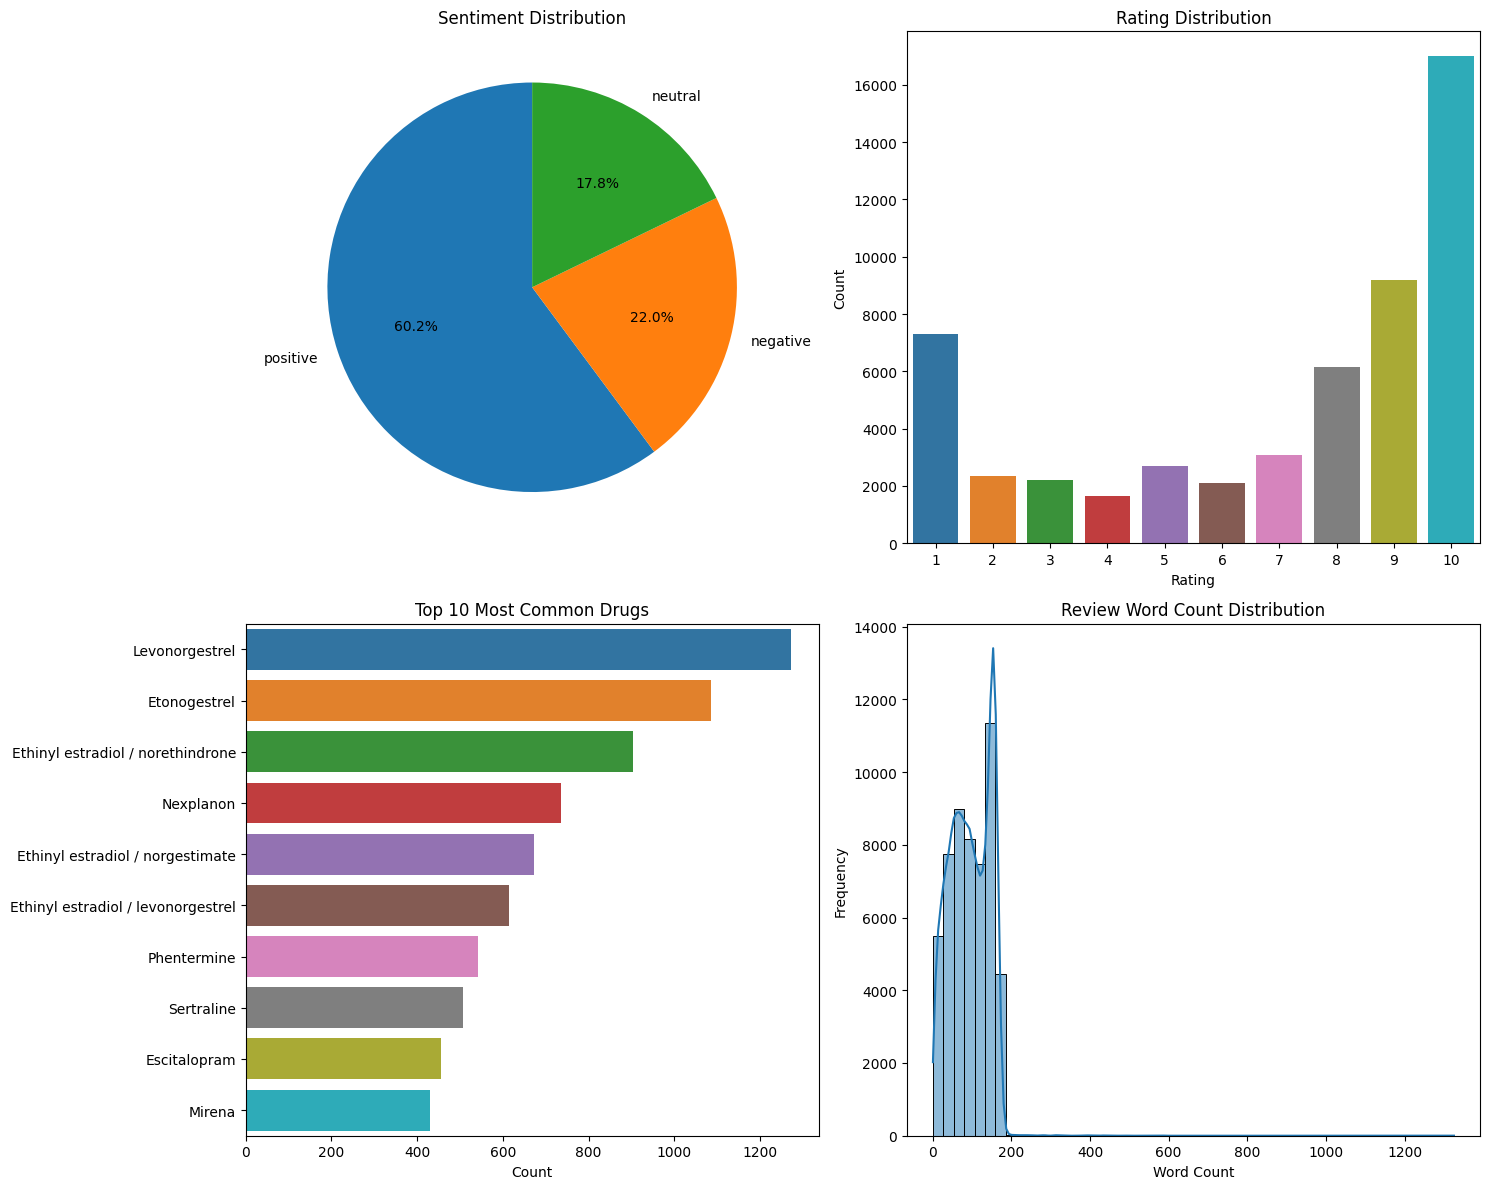


Preparing Data for SketchEngine
Data exported to sketch_engine_data directory for SketchEngine analysis
Check sketch_engine_guide.txt for usage instructions

Preparing Data for Weka
Preparing data for Weka...
Extracting features using TF-IDF...
Exporting to ARFF file: dataset/drug_reviews_weka.arff
Successfully exported Weka data, feature count: 500
Weka usage guide saved to: dataset/weka_guide.txt

ChatGPT Drug Review Analysis
No API key provided, generating example prompts for manual analysis
Generated 3 ChatGPT prompts, saved to chatgpt_prompts.txt
Please manually input these prompts to ChatGPT and record the analysis results
ChatGPT usage guide saved to chatgpt_guide.txt

Training and evaluation of traditional machine learning models
Balanced sampling dataset...
The size of the balanced dataset: 28737

training logistic model...
Creating sentiment analysis model...
Training logistic model...
Model accuracy: 0.6512

Confusion matrix:
[[1375  388  170]
 [ 419 1038  463]
 [ 164  401 

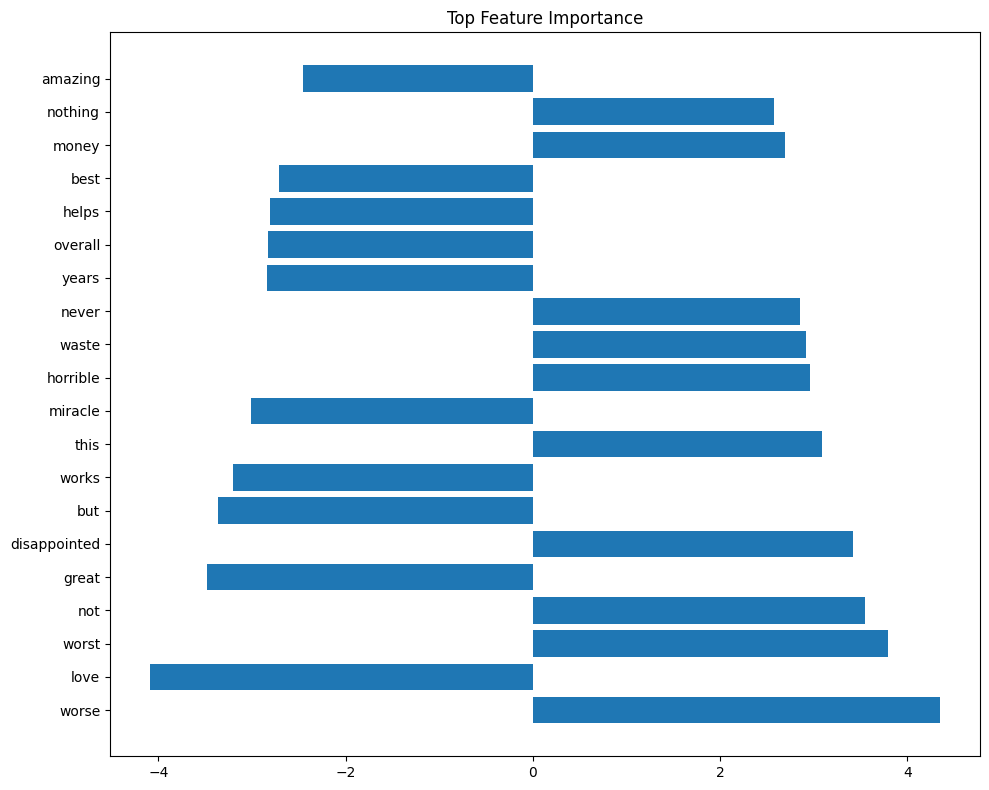


The most important feature of:
worse: 4.3554
love: -4.0951
worst: 3.7954
not: 3.5462
great: -3.4760
disappointed: 3.4245
but: -3.3610
works: -3.2082
this: 3.0947
miracle: -3.0133

Out of Sample Forecast

Sample comment prediction results:
Comment (truncated to 100 characters): no side effects nausea, headaches,etc regulated my period...
emotion forecasting: positive

Comment (truncated to 100 characters): when i originally got sick with insomnia and mania, i was prescribed seroquel. 5 years later was adm...
emotion forecasting: positive

Comment (truncated to 100 characters): as an adult with adhd concerta is the way to go. focused and able to complete tasks. although the la...
emotion forecasting: neutral

Comment (truncated to 100 characters): what a waste of money i paid a copay of 400 for 3 injections in my left and right knee. i am bone on...
emotion forecasting: negative

Comment (truncated to 100 characters): took first pill yesterday. noticed almost immediately no appetite. go

In [ ]:
def run_comprehensive_study(data_path="dataset/drugsComTest_raw.csv"):
    """
    Run comprehensive drug review sentiment analysis study, integrating multiple data mining and text analysis tools
    """
    print("=" * 50)
    print("Starting Comprehensive Drug Review Sentiment Analysis Study")
    print("=" * 50)

    # 1. Data cleaning
    cleaned_df = clean_drug_reviews(
        data_path, "dataset/drugsComTest_cleaned.csv")

    # 2. Data exploration
    print("\n" + "=" * 50)
    print("Data Exploration")
    print("=" * 50)
    stats = explore_drug_reviews(cleaned_df)

    # 3. Data visualization
    visualize_data(stats)

    # 4. Prepare data for SketchEngine
    print("\n" + "=" * 50)
    print("Preparing Data for SketchEngine")
    print("=" * 50)
    sketch_results = integrate_sketch_engine(cleaned_df)


    # 5. Prepare data for Weka
    print("\n" + "=" * 50)
    print("Preparing Data for Weka")
    print("=" * 50)
    weka_results = export_for_weka(cleaned_df)

    # 6. ChatGPT analysis (generates prompts if no API key provided)
    chatgpt_results = analyze_with_chatgpt(cleaned_df)

    # 7. Transformer model analysis
    # try:
    #     print("\n" + "=" * 50)
    #     print("Attempting to perform Transformer model analysis...")
    #     transformer_results = analyze_with_transformers(cleaned_df, sample_size=3)
    # except Exception as e:
    #     print(f"Transformer model analysis failed, skipping this step: {str(e)}")
    #     # Provide a placeholder result so subsequent code can continue executing
    #     transformer_results = {
    #         "error": str(e),
    #         "status": "failed",
    #         "message": "Unable to use Transformer model due to network connection issues. Program has skipped this part and continued."
    #     }
    
    # 8. Traditional machine learning model training
    print("\n" + "=" * 50)
    print("Training and evaluation of traditional machine learning models")
    print("=" * 50)
    
    # Sample evenly from each emotion category to balance the dataset
    print("Balanced sampling dataset...")
    min_class_count = min(stats['sentiment_counts'])
    balanced_df = pd.concat([
        cleaned_df[cleaned_df['sentiment'] == sentiment].sample(min_class_count, random_state=42)
        for sentiment in stats['sentiment_counts'].index
    ])
    print(f"The size of the balanced dataset: {len(balanced_df)}")
    
    # Train different models and make comparisons
    models = {}
    for model_type in ['logistic', 'naive_bayes', 'svm', 'random_forest']:
        print(f"\ntraining {model_type} model...")
        model_results = create_sentiment_model(balanced_df, model_type)
        models[model_type] = model_results
    
    # Find out the best model
    best_model = max(models.items(), key=lambda x: x[1]['accuracy'])
    print(
        f"\nThe best model is {best_model[0]}, accuracy rate {best_model[1]['accuracy']:.4f}")
    
    # 9. Feature Importance Analysis
    print("\n" + "=" * 50)
    print("Feature Importance Analysis")
    print("=" * 50)
    top_features = analyze_feature_importance(best_model[1])
    print("\nThe most important feature of:")
    for feature, importance in top_features[:10]:
        print(f"{feature}: {importance:.4f}")
    
    # 10. Sample prediction (Retain the original function)
    print("\n" + "=" * 50)
    print("Out of Sample Forecast")
    print("=" * 50)
    
    # Randomly select some samples for prediction
    sample_reviews = cleaned_df['review_clean'].sample(5, random_state=42).tolist()
    
    vectorizer = best_model[1]['vectorizer']
    model = best_model[1]['model']
    
    sample_vectors = vectorizer.transform(sample_reviews)
    predictions = model.predict(sample_vectors)
    
    print("\nSample comment prediction results:")
    for review, prediction in zip(sample_reviews, predictions):
        print(f"Comment (truncated to 100 characters): {review[:100]}...")
        print(f"emotion forecasting: {prediction}\n")
    
    # 11. Comparison report of multiple tools
    print("\n" + "=" * 50)
    print("Comparison report of multiple tools")
    print("=" * 50)
    
    
    print("=" * 50)
    print("Comprehensive research completed!")
    print("=" * 50)
    
    return {
        'cleaned_df': cleaned_df,
        'stats': stats,
        'models': models,
        'best_model': best_model,
        'top_features': top_features,
        'sketch_results': sketch_results,
        'weka_results': weka_results,
        'chatgpt_results': chatgpt_results,
        # 'transformer_results': transformer_results
    }


# Conduct pilot research
if __name__ == "__main__":
    results = run_comprehensive_study()

# Further Analysis and Investigation
 After completing the basic sentiment analysis, we can conduct some more in-depth analyses:


Analyzing Sentiment Distribution by Drug Name


<Figure size 1200x800 with 0 Axes>

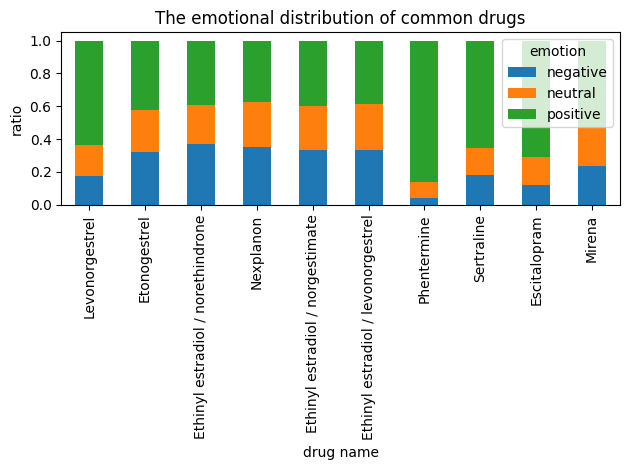


Analyzing Sentiment Trends Over Time


<Figure size 1500x800 with 0 Axes>

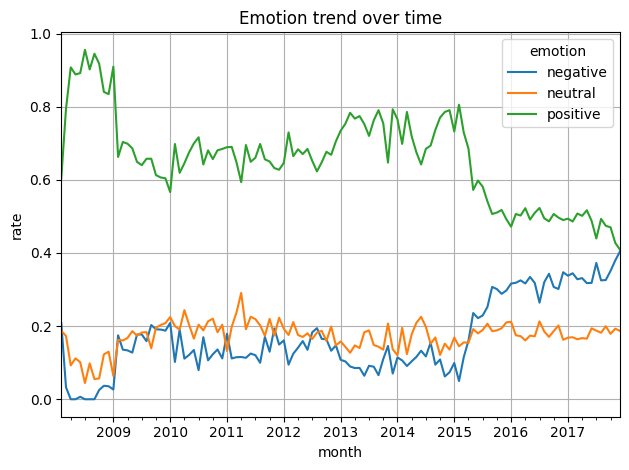


Most Common Words in Each Sentiment Category

Positive Common words:
.: 170296
,: 83779
!: 19845
day: 12054
side: 11497
years: 11349
effects: 9754
taking: 9682
take: 9614
first: 9104
pain: 8916
like: 8092
started: 8080
2: 8062
get: 8029
days: 7902
months: 7678
time: 7557
feel: 7450
3: 6907

Neutral Common words:
.: 51302
,: 26724
taking: 3534
day: 3527
!: 3279
side: 3262
months: 3183
first: 3083
started: 3020
like: 2793
get: 2752
effects: 2725
2: 2639
days: 2599
pain: 2592
time: 2573
take: 2442
3: 2378
feel: 2320
period: 2270

Negative Common words:
.: 59046
,: 31019
!: 7630
day: 3877
taking: 3770
like: 3375
pain: 3371
months: 3321
started: 3073
days: 3030
side: 2978
get: 2952
2: 2826
first: 2749
would: 2739
pill: 2689
time: 2671
effects: 2597
3: 2596
took: 2529


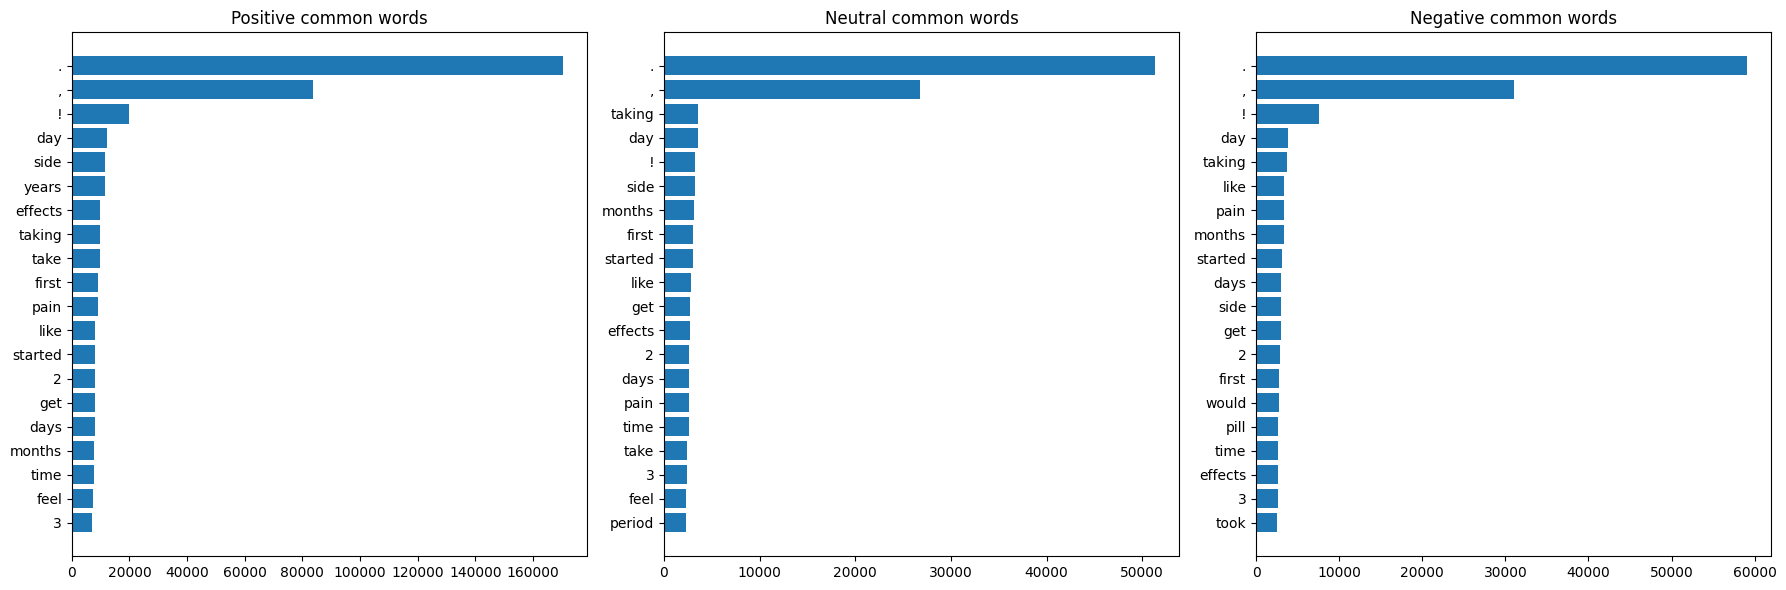

In [14]:
def advanced_analysis(results):
    """
    Perform advanced analysis
    
    Parameters:
        results: Pilot study results
    """
    cleaned_df = results['cleaned_df']
    
    # 1. Analyze sentiment distribution by drug name
    print("\n" + "=" * 50)
    print("Analyzing Sentiment Distribution by Drug Name")
    print("=" * 50)
    
    # Get the 10 most common drugs
    top_drugs = cleaned_df['drugName'].value_counts().head(10).index
    
    # Calculate sentiment proportions for each drug
    drug_sentiment = {}
    for drug in top_drugs:
        drug_df = cleaned_df[cleaned_df['drugName'] == drug]
        sentiment_counts = drug_df['sentiment'].value_counts(normalize=True)
        drug_sentiment[drug] = sentiment_counts
    
    # Visualization
    drug_sentiment_df = pd.DataFrame(drug_sentiment).T.fillna(0)
    plt.figure(figsize=(12, 8))
    drug_sentiment_df.plot(kind='bar', stacked=True)
    plt.title('The emotional distribution of common drugs')
    plt.xlabel('drug name')
    plt.ylabel('ratio')
    plt.legend(title='emotion') 
    plt.tight_layout()
    plt.savefig('drug_sentiment_distribution.png')
    plt.show()
    
    # 2. Analyze sentiment trends over time
    print("\n" + "=" * 50)
    print("Analyzing Sentiment Trends Over Time")
    print("=" * 50)
    
    # Convert dates to datetime type
    cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
    
    # Aggregate by month
    cleaned_df['month'] = cleaned_df['date'].dt.to_period('M')
    sentiment_by_month = cleaned_df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
    
    # Calculate monthly sentiment proportions
    sentiment_ratio = sentiment_by_month.div(sentiment_by_month.sum(axis=1), axis=0)
    
    # Visualization
    plt.figure(figsize=(15, 8))
    sentiment_ratio.plot(kind='line')
    plt.title('Emotion trend over time')
    plt.xlabel('month')
    plt.ylabel('rate')
    plt.legend(title='emotion')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('sentiment_trend.png')
    plt.show()
    
    # 3. Word frequency analysis - most common words in each sentiment category
    print("\n" + "=" * 50)
    print("Most Common Words in Each Sentiment Category")
    print("=" * 50)
    
    from collections import Counter
    
    # Count word frequencies for each sentiment
    sentiment_word_freq = {}
    for sentiment in cleaned_df['sentiment'].unique():
        sentiment_df = cleaned_df[cleaned_df['sentiment'] == sentiment]
        all_words = [word for tokens in sentiment_df['tokens_no_stopwords'] for word in tokens]
        word_freq = Counter(all_words).most_common(20)
        sentiment_word_freq[sentiment] = word_freq
    
    # Print results
    for sentiment, word_freq in sentiment_word_freq.items():
        print(f"\n{sentiment.title()} Common words:")
        for word, freq in word_freq:
            print(f"{word}: {freq}")
    
    # Visualization
    fig, axes = plt.subplots(1, len(sentiment_word_freq), figsize=(18, 6))
    
    for i, (sentiment, word_freq) in enumerate(sentiment_word_freq.items()):
        words, freqs = zip(*word_freq)
        axes[i].barh(range(len(words)), freqs, align='center')
        axes[i].set_yticks(range(len(words)))
        axes[i].set_yticklabels(words)
        axes[i].invert_yaxis()
        axes[i].set_title(f'{sentiment.title()} common words')
    
    plt.tight_layout()
    plt.savefig('sentiment_word_freq.png')
    plt.show()
    
    return {
        'drug_sentiment': drug_sentiment_df,
        'sentiment_trend': sentiment_ratio,
        'sentiment_word_freq': sentiment_word_freq
    }

# Run advanced analysis
if __name__ == "__main__":
    if 'results' in locals():
        advanced_results = advanced_analysis(results)
    else:
        results = run_comprehensive_study()
        advanced_results = advanced_analysis(results)